In [1]:
## Options
import pandas as pd
from PI_client import pi_client
pi = pi_client()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

%load_ext autoreload
%autoreload 2

## Imports

## Mac imports
# import sys
# toolPath = r'/Users/decolvin/Box Sync/UCD_ECO_coding/mypy'
# sys.path.append(toolPath)

## Main Imports
import mnv14 as mnv
print(mnv.version)
import matplotlib.pyplot as plt
print("Success!")

Version 1.4
Success!


### Local Data Loading

In [2]:
filePath = 'data/gbsfkilledvif.xlsx'
data = pd.read_excel(filePath, header=0, index_col=0, parse_date=True)
print(data.columns)

Index([u'chw', u'steam', u'ele', u'OAT'], dtype='object')


### PI Data Loading

In [3]:
tags = pi.search_by_point('*shields*kbtu*')[0]
#tags += pi.search_by_point('*shields*kbtu*')[0]

print(tags)

[u'Shields_ChilledWater_Demand_kBtu', u'Shields_Electricity_Demand_kBtu', u'Shields_Steam_Demand_kBtu']


#### Pull tags

In [4]:
startDate = '2017-01-01'
endDate = '2018-01-01'
interval = '1 hour' #Can be "minute" "hour" "day"
calculation = 'calculated' # Redundant?

# data = pi.get_stream_by_point(tags, start=startDate, end=endDate, interval=interval, calculation=calculation)

# Data Section

Q(75%): 903.41 Q(25%): 775.42
IQR value is 127.99
Ceiling adjusted by IQR - Now 1415.37
Floor adjusted by IQR   - Now 263.47
OAT being loaded from master file


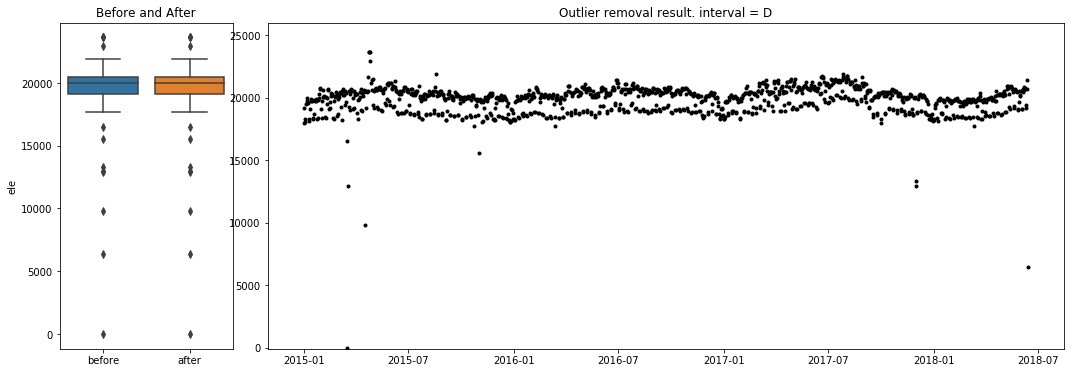

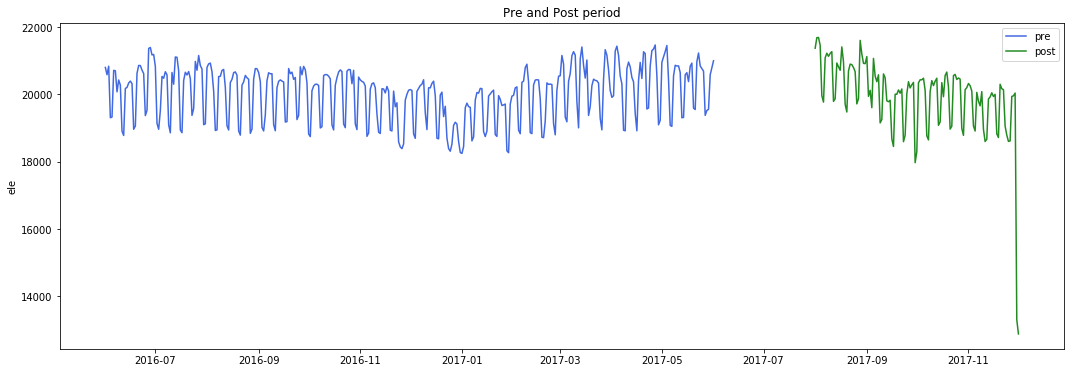

In [5]:
inputDict = {'IQRmult' : 4.0,
             'IQR' : 'y', 
             'resampleRate' : 'D', #'D' for daily 'H' for hourly
             'OATsource' : 'file', #'self' or 'file'
             'OATname' : 'OAT', #Name of OAT column if OATsource is 'self'} #only needed with sliceType : 'ranges'
             'sliceType' : 'ranges', #half, middate, ranges
             'midDate' : '2017-01-01', #only needed with sliceType : 'middate'
             'dateRanges' : ['2016-06-01','2017-06-01','2017-08-01','2017-12-01'], #only needed with sliceType : 'ranges'
            }

dc = mnv.data_handler(data[data.columns[2]], inputDict)
dc.default_clean()

## Run the next line incase the y-range is FUBAR
dc._outlier_plot(dc.modifiedData[dc.com], yrange=(-100,dc.modifiedData[dc.com].max()*1.1)) 

# plot 3
dc._pre_post_plot()

# Many Linear Models

Could not calculate VIF for C(hour)
Exception caught: Arrays cannot be empty
Could not calculate VIF for C(hour)
Exception caught: Arrays cannot be empty


C:\Users\koshnick\AppData\Local\conda\conda\envs\py27\lib\site-packages\statsmodels\regression\linear_model.py:1554: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model
C:\Users\koshnick\AppData\Local\conda\conda\envs\py27\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\koshnick\AppData\Local\conda\conda\envs\py27\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\koshnick\AppData\Local\conda\conda\envs\py27\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


        AIC       AR2        R2     cvrmse postDiff                                         params                                            summary
64  4191.52  0.841036  0.848684  0.0154294  11698.7             CDH + HDH2 + C(weekday) + C(month)                              OLS Regression Res...
33  4194.21  0.852859  0.859938  0.0155007  14383.8             CDH2 + HDH + C(weekday) + C(month)                              OLS Regression Res...
4   4195.39   0.84775  0.855075  0.0155319  12431.3   CDH2 + HDH + C(hour) + C(weekday) + C(month)                              OLS Regression Res...
17  4216.38  0.839394  0.847121  0.0161004  11232.5    CDH + HDH + C(hour) + C(weekday) + C(month)                              OLS Regression Res...
5   4219.17  0.831222  0.839342  0.0161774  13415.2            CDH2 + HDH2 + C(weekday) + C(month)                              OLS Regression Res...
9   4219.89  0.839694  0.847407  0.0161976  14444.5   CDH + HDH2 + C(hour) + C(weekday) + C(month)  

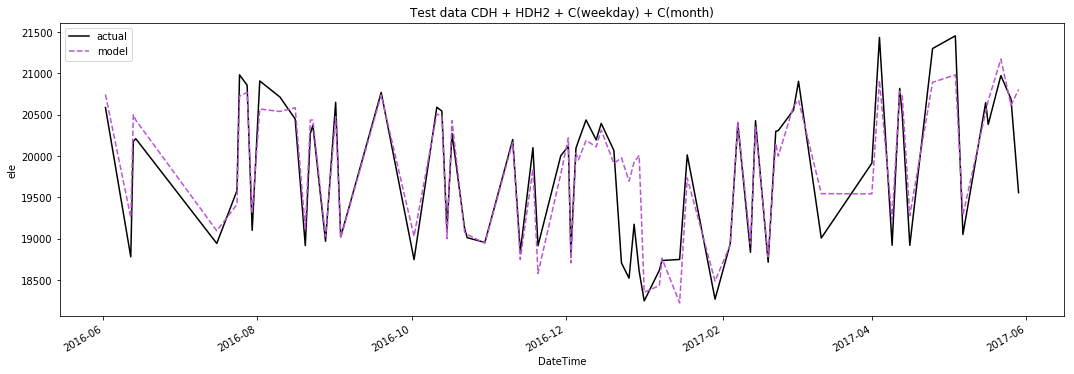

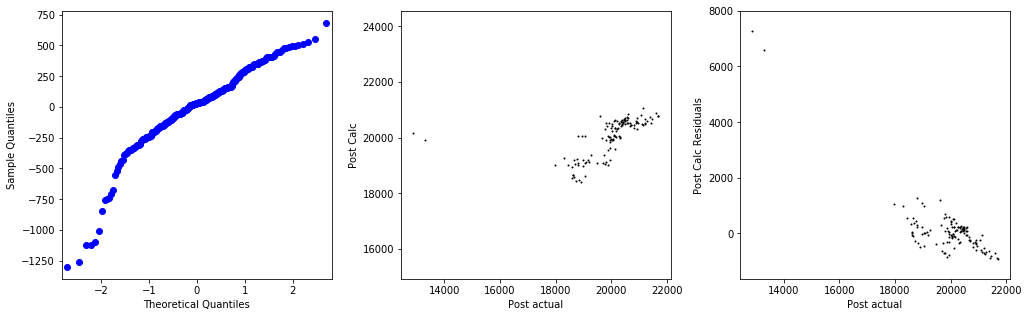

In [6]:
modelDict = {'params': ['CDH','HDH','month','hour','weekday'],
             'testTrainSplit': 'random',
             'randomState': None,
             'testSize': 0.2,
             'commodityRate': 0.056,
             'paramPermuteList': ['', 'C(hour)', 'C(weekday)', 'C(month)']}

allmod = mnv.many_ols(dc.pre, dc.post, modelDict)

allmod.run_all_linear()
print(allmod.statsPool[0:20])
allmod.plot_pool(1)
modelDict['params'] = allmod.statsPool.iloc[0]['params']

# Single Linear Model

             VIF
const  33.515381

Kfold
         R2       AR2            mse
2  0.862376  0.855445   90598.555172
4  0.852551  0.845125   97277.157616
0  0.843417  0.835503  105379.540628
1  0.841906  0.833945  108746.847076
3  0.833712  0.825337  117478.077248
2          87.201197
4          93.629358
0         101.427909
1         104.668945
3         113.072762
mse    103896.000000
dtype: float64


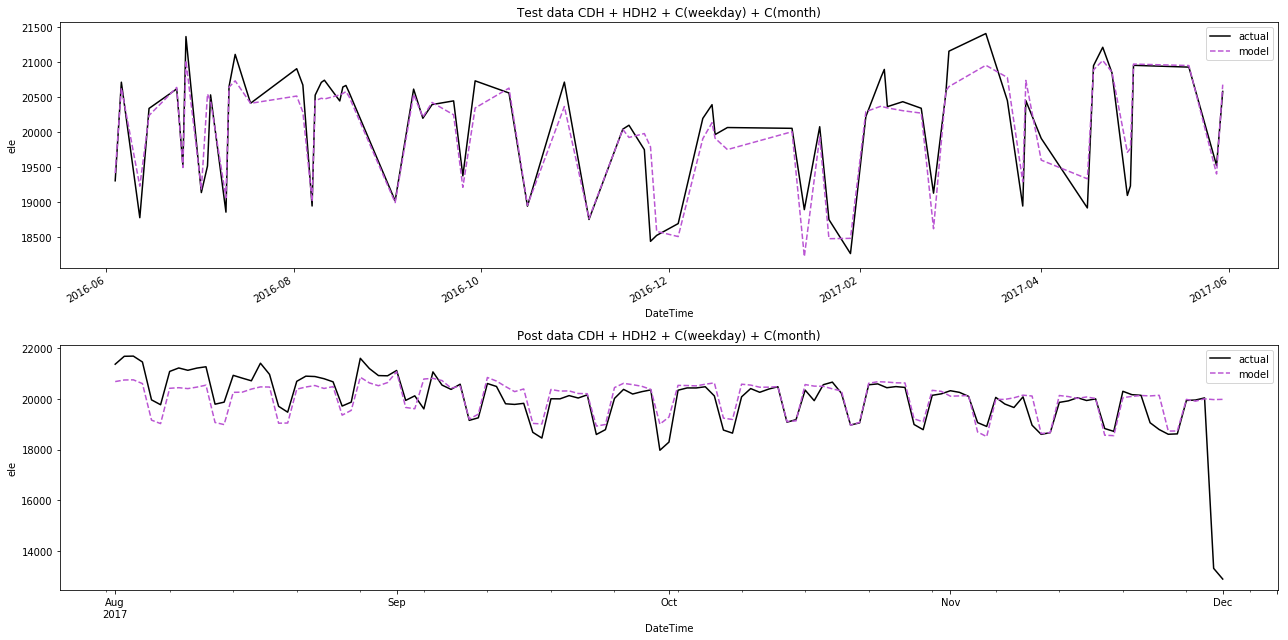

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ele   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     106.6
Date:                Mon, 16 Jul 2018   Prob (F-statistic):          1.23e-102
Time:                        16:09:54   Log-Likelihood:                -2095.2
No. Observations:                 292   AIC:                             4220.
Df Residuals:                     277   BIC:                             4275.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.881e+04    109.056    172.473      0.000    1.86e+04     1.9e+04
C(weekday)[T.1L]  1392.0246     42.456     32.788      0.000    1308.448    1475.602
C(month)[T.2L]     196.5732    104.027      1.890      0.060      -8.210     401.356
C(month)[T.3L]     586.7357    111.900      5.243      0.000     366.454     807.018
C(month)[T.4L]     648.6790    116.724      5.557      0.000     418.900     878.458
C(month)[T.5L]     280.5994    125.611      2.234      0.026      33.325     527.874
C(month)[T.6L]     -22.8583    140.864     -0.162      0.871    -300.157     254.441
C(month)[T.7L]     -41.8768    144.301     -0.290      0.772    -325.942     242.189
C(month)[T.8L]    -151.9245    138.164     -1.100      0.272    -423.909     120.060
C(month)[T.9L]     -76.4422    134.705     -0.567      0.571    -341.617     188.733
C(month)[T.10L]    171.2251    117.966      1.451      0.148     -60.998     403.448
C(month)[T.11L]    -38.4819    108.283     -0.355      0.723    -251.644     174.680
C(month)[T.12L]     36.3374     90.225      0.403      0.687    -141.277     213.952
CDH                  1.7552      0.300      5.855      0.000       1.165       2.345
HDH2                -0.0026      0.001     -4.948      0.000      -0.004      -0.002
==============================================================================
Omnibus:                       82.025   Durbin-Watson:                   1.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.082
Skew:                          -1.291   Prob(JB):                     4.41e-48
Kurtosis:                       6.355   Cond. No.                     1.51e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
mod = mnv.ols_model(dc.pre, dc.post, modelDict)
mod.model_plot()

mod.kfold()
mod.calculate_vif()

print(mod.vif[mod.vif['VIF'] > 10])

print('\nKfold')
print(mod.kfoldStats)
print(mod.kfoldRelative)

plt.show() # Show plot before Stats summary
mod.Fit.summary()

### Savings

Savings = $651.8


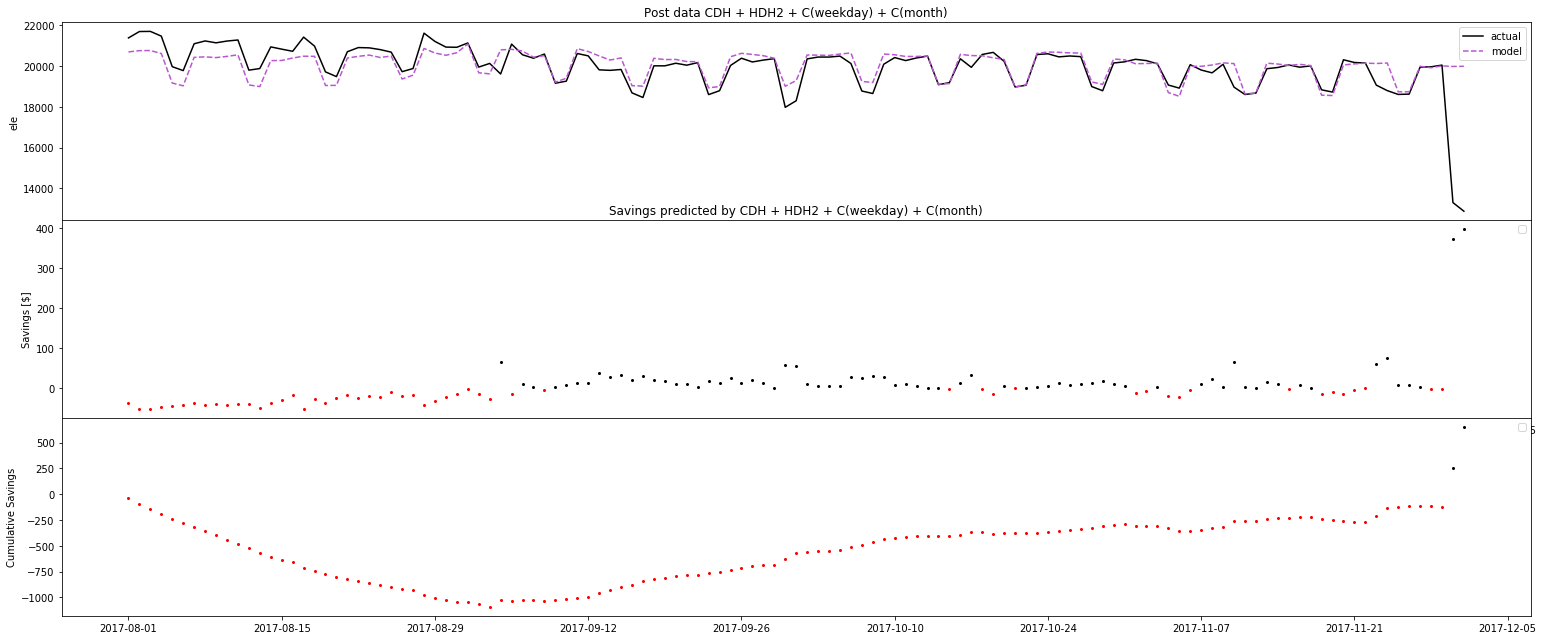

In [8]:
#rates = {'chw':0.056, 'steam':0.0157, 'elec':0.030} #kBTU prices for 2016(?)
#commodity = 'chw'

print("Savings = $" +str(round(mod.postCumsum * mod.params.commodityRate,1)))
mod.savings_plot(yaxis='dollars')